In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
import seawater

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
# Similar to 14 except removed all the processing code.

### Plan

Need to compare New Production, CO2 flux and SST at different locations and for different timescale resolutions. 
Assess which is the best Ensemble for Each of these.


What do we need

- Work in mols.


- CAFE New Production (Need to make detritus calculation)
- CO2 flux 

- New Production estimates
- Chlor A in mg CHL? 
- Landschutzer CO2 flux estimate (How about DELTA pCO2?)
- Reynolds OISST product


- And then detrend and deseasonalise to get different data product resolutions.

- Plot all ensembles over a Year?


In [3]:
#client

In [4]:
# Assumes data was loaded previously in 12 Validation run
use_dask=True
ensemble=25

In [83]:

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42473 instead
  warnings.warn(


In [84]:
cluster#.close()

In [85]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/42473/status,
Dashboard: /proxy/42473/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.156:41795,Workers: 0
Dashboard: /proxy/42473/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [9]:
ls /g/data/xv83/dcfp/CAFE60v1

atmos_isobaric_daily.zarr.zip*  ocean_daily.zarr.zip*
atmos_isobaric_month.zarr.zip*  ocean_ens_mean_at_analysis.zarr.zip*
ice_month.zarr.zip*             ocean_force_month.zarr.zip*
land_month.zarr.zip*            ocean_month.zarr.zip*
ocean_bgc_daily.zarr.zip*       ocean_scalar_month.zarr.zip*
ocean_bgc_month.zarr.zip*


In [10]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40),)

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [11]:
# Load OBS

# Landschutzer
land_co2=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365 #g/m2/day
land_co2=(land_co2.fgco2_smoothed.sel(lon=slice(120,290),lat=slice(-40,40))/12)*1000#/1000 #mmol/m2/day to match cafe. (ingassing is positive, outgassing neg)
#land_dpco2=(land_co2.pco2.sel(lon=slice(120,290),lat=slice(-40,40))


# Reynolds SST
rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc')
rey_sst=rey_sst.sst.sel(lon=slice(120,290),lat=slice(-40,40))
rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc').sel(lon=slice(120,290),lat=slice(-40,40))
#(obs_current.U_320.median(dim='time').sel(lat=0,method='nearest')).interpolate_na(dim='depth').plot.contourf(cmap='bwr')

In [12]:
# TOA Moorings
run_obs_current=False
if run_obs_current==True:
    obs_current=xr.open_mfdataset('../external_data/mooring_u_current/*.cdf')
    obs_current=obs_current.where(obs_current<=1e20)/100
    obs_current['time']=obs_current.time.astype('datetime64[M]')
    obs_current.to_netcdf('../processed_data/tao_adcp.nc')
obs_current=xr.open_dataset('../processed_data/tao_adcp.nc')

In [13]:
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_alldep.nc').chunk('auto').__xarray_dataarray_variable__
#anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__

In [14]:
anth_dic_cafe

<xarray.DataArray '__xarray_dataarray_variable__' (time: 731, st_ocean: 50,
                                                   lat: 140, lon: 170)>
dask.array<xarray-__xarray_dataarray_variable__, shape=(731, 50, 140, 170), dtype=float32, chunksize=(87, 50, 70, 85), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

In [15]:
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_alldep.nc').chunk('auto').__xarray_dataarray_variable__
anth_dic_cafe_integration=anth_dic_cafe.sum(dim='st_ocean')
anth_dic_cafe_integration_trend=xarray_get_trend(anth_dic_cafe_integration.sel(time=slice('2000-01-01','2020-01-01')).chunk(dict(time=-1)))
# Need to calculate the Trend on this. and plot ONto Figure instead of DIC/adic. 

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,


In [16]:
# Load the data we created


npp=xr.open_dataset('../processed_data/npp_rg/avg_npp_cafe.nc').avg_npp.chunk('auto')


cafe_u=xr.open_dataset('../processed_data/physics_ds/u_physics_feb7.nc').u
cafe_v=xr.open_dataset('../processed_data/physics_ds/v_physics_feb7.nc').v
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt
cafe_temp=xr.open_dataset('../processed_data/physics_ds/temp_physics_feb7.nc').temp
cafe_sst=xr.open_dataset('../processed_data/physics_ds/sst_physics_feb7.nc').sst
cafe_age=xr.open_dataset('../processed_data/physics_ds/age_global_physics_feb7.nc').age_global
#cafe_salt=xr.open_dataset('../processed_data/physics_ds/salt_physics_feb7.nc').salt
cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
dic=xr.open_dataset('../processed_data/dic_pac_feb7.nc') #physics_ds
upwelling_cafe=cafe_wt.sel(sw_ocean=-100,method='nearest')

cafe_u_tx=xr.open_dataset('../processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans
cafe_y_tx=xr.open_dataset('../processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans
cafe_u_tx_gm=xr.open_dataset('../processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('../processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm


adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__


cafe_pprod=xr.open_dataset('../processed_data/physics_ds/pprod_gross_2d_bgc_feb7.nc').pprod_gross_2d
cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural

cafe_pCO2=xr.open_dataset('../processed_data/physics_ds/pco2_bgc_feb7.nc').pco2
cafe_paCO2=xr.open_dataset('../processed_data/physics_ds/paco2_bgc_feb7.nc').paco2
#cafe_co2flux=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
#cafe_natco2flux=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
#age=xr.open_dataset('../processed_data/physics_ds/pCO2_bgc_feb07.nc').age_global


dic_tx_v=xr.open_dataset('../processed_data/dic_v.nc').__xarray_dataarray_variable__
dic_tx_u=xr.open_dataset('../processed_data/dic_u.nc').__xarray_dataarray_variable__
#dic_tx_w=xr.open_dataset('../processed_data/dic_w.nc').__xarray_dataarray_variable__

anth_dic_tx_v=xr.open_dataset('../processed_data/dic_v_anth.nc').__xarray_dataarray_variable__
anth_dic_tx_u=xr.open_dataset('../processed_data/dic_u_anth.nc').__xarray_dataarray_variable__
#anth_dic_tx_w=xr.open_dataset('../processed_data/dic_w_anth.nc').__xarray_dataarray_variable__


# TREND FILES
cafe_co2_natural_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_co2_natural_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_co2_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_co2_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_sst_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_sst_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_u_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_u_mean_depth_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_v_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_v_mean_depth_trend_ensemble.nc')['1998-01 to 2015-01']
land_co2_trend=xr.open_dataset('../processed_data/var_ensembles/land_co2_trend_ensemble.nc')['1998-01 to 2015-01']
rey_sst_trend=xr.open_dataset('../processed_data/var_ensembles/rey_sst.sst_trend_ensemble.nc')['1998-01 to 2015-01']
tao_u_trend=xr.open_dataset('../processed_data/var_ensembles/obs_current.U_320_trend_ensemble.nc')['1998-01 to 2015-01']
tao_v_trend=xr.open_dataset('../processed_data/var_ensembles/obs_current.V_321_trend_ensemble.nc')['1998-01 to 2015-01']
dic_mean_depth_trend=xr.open_dataset('../processed_data/var_ensembles/dic_mean_depth_trend_ensemble.nc')['1998-01 to 2015-01']
adic_mean_depth_trend=xr.open_dataset('../processed_data/var_ensembles/adic_mean_depth_trend_ensemble.nc')['1998-01 to 2015-01']
upwelling_cafe_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_pprod_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_pprod_trend=xr.open_dataset('../processed_data/var_ensembles/upwelling_cafe_trend_ensemble.nc')['1998-01 to 2015-01']
#npp_cafe_trend=xr.open_dataset('../processed_data/var_ensembles/npp_trend_ensemble.nc')['1998-01 to 2015-01']
#npp_cafe_trend=xr.open_mfdataset('../processed_data/var_ensembles/npp_slices/*nc',concat_dim='timeperiod')
# Npp Load Hack...
npp_cafe_trend=xr.open_mfdataset('../processed_data/var_ensembles/npp_slices/*nc')
holder=[]
for date in list(npp_cafe_trend):
    holder.append(npp_cafe_trend[date])#,dim='timeperiod')#.to_dataarray()
npp_cafe_trend=xr.concat(holder,dim='timeperiod')


co2_rodenbeck=(xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid.nc').sel(lon=slice(120,290),lat=slice(-40,40)).co2flux_ocean/12)*1000 #to mmolC

In [17]:
#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values

/local/v45/np1383/tmp/ipykernel_3377415/3283648372.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
/local/v45/np1383/tmp/ipykernel_3377415/3283648372.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
/local/v45/np1383/tmp/ipykernel_3377415/3283648372.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
/local/v45/np1383/tmp/ipykernel_3377415/3283648372.py:25: FutureWarning: The frame.appen

cafe_u=xr.open_dataset('../processed_data/physics_ds/u_physics_feb7.nc').u
cafe_v=xr.open_dataset('../processed_data/physics_ds/v_physics_feb7.nc').v
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt
cafe_temp=xr.open_dataset('../processed_data/physics_ds/temp_physics_feb7.nc').temp
cafe_sst=xr.open_dataset('../processed_data/physics_ds/sst_physics_feb7.nc').sst
cafe_age=xr.open_dataset('../processed_data/physics_ds/age_global_physics_feb7.nc').age_global
cafe_salt=xr.open_dataset('../processed_data/physics_ds/salt_physics_feb7.nc').salt
cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
dic=xr.open_dataset('../processed_data/dic_pac_feb7.nc') #physics_ds
upwelling_cafe=cafe_wt.sel(sw_ocean=-100,method='nearest')

cafe_u_tx=xr.open_dataset('../processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans
cafe_y_tx=xr.open_dataset('../processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans
cafe_u_tx_gm=xr.open_dataset('../processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('../processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm


In [18]:
pwd

'/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code'

In [19]:
# I cut out ensemble 25 previously, path is '/g/data4/xv83/np1383/processed_data/physics_ds/ .... tx_trans_physics_feb7.nc

dic=xr.open_dataset('../processed_data/dic_pac_feb7.nc') #physics_ds


cafe_x_tx=xr.open_dataset('../processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans
cafe_y_tx=xr.open_dataset('../processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans
cafe_x_tx_gm=xr.open_dataset('../processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('../processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm
# y is v and x is u directions?


adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__

In [20]:
# Area grid  for Depth??
#!ls /g/data/xv83/rxm599
#/area.nc
# 

#docn=phys
#mdepth=docn.st_ocean.copy()
#dbot=np.copy(docn.sw_ocean)
#dthick=dbot*0
#dthick[1:50]=dbot[1:50]-dbot[0:49]

#dthick[0]=dbot[0]
#print(dthick,dbot)
#mdepth=mdepth*0+dthick
#mdepth 

## Add a few custom functions ive been making.
wrap functions to wrap functions that wrap functions
who wraps the wrapper for the wrapper? 

In [21]:

def plot_pacific(dat,levels=None,cmap='bwr'):

    fig = plt.figure(figsize=(12,7))

    # this declares a recentered projection for Pacific areas
    proj = ccrs.PlateCarree(central_longitude=180)
    proj._threshold /= 20.  # to make greatcircle smooth

    ax = plt.axes(projection=proj)
    # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree())

    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    lonm,latm=np.meshgrid(dat.lon,dat.lat)
    if levels is None:
        g=ax.contourf(dat.lon,dat.lat,dat, transform=ccrs.PlateCarree(),cmap=cmap)
    else:
        g=ax.contourf(dat.lon,dat.lat,dat, transform=ccrs.PlateCarree(),cmap=cmap,levels=levels)
    plt.colorbar(g,ax=ax,location='bottom',orientation='horizontal')
    # plot greatcircle arc

    ax.add_feature(cfeature.LAND, color='lightgray', zorder=100, edgecolor='k')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.coastlines()

    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)

    plt.show()
    
    
#Seasonality?
#plot_pacific(sst_rey.groupby('time.month').mean().std(dim=['month']))

#stat=xarray_get_trend(rey_sst)
#plot_pacific(stat.sel(parameter=0)*365)

#stat=xarray_get_trend(sst_cafe.sel(ensemble=25))
#plot_pacific(stat.sel(parameter=0)*365)

In [22]:
def plot_pacific_subplot(dat,sb,title,levels=None,units=None,cmap='bwr',extend='neither',shrink=0.85,small_plot=False,remap=False):
   
    # this declares a recentered projection for Pacific areas
    if remap==False:
        proj = ccrs.PlateCarree(central_longitude=180)
        proj1=ccrs.PlateCarree()
        
    #elif remap==True:
    #    proj = ccrs.Miller(central_longitude=180)
    #    proj1=ccrs.Miller()


    if isinstance(sb,int):
        ax=plt.subplot(sb,projection=proj)
    else:
        ax=plt.subplot(sb[0],sb[1],sb[2],projection=proj)
    # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    if small_plot==True:
        ax.set_extent([150, 250, -10, 10], crs=proj1)
    elif small_plot==False:    
        ax.set_extent([120, 290, -40, 40], crs=proj1)

    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    lonm,latm=np.meshgrid(rey_sst.lon,rey_sst.lat)
    if isinstance(levels,type(None)):
         g=ax.contourf(dat.lon,dat.lat,dat, transform=proj1,cmap=cmap, extend=extend)
    else:
         g=ax.contourf(dat.lon,dat.lat,dat, transform=proj1,cmap=cmap,levels=levels, extend=extend)
   #,levels=levels)#vmin=vmin,vmax=vmax)
    #ax.clim(vmin,vmax)
    cb=plt.colorbar(g,ax=ax,location='bottom',orientation='horizontal',shrink=shrink)#,vmin=vmin,vmax=vmax)
    if units is not None:
        cb.set_label(units)#, rotation=270)
        
    # plot greatcircle arc
    #ax.set_clim(vmin,vmax)
    #plt.clim(vmin,vmax)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=100, edgecolor='k')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.coastlines()
    ax.set_title(title)
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
    ax.set_aspect('auto')

# NEW FIGURES HERE

Mean Left Tr Right


- Rey SST:   
    - rey_sst
- CAFE SST
    - sst_cafe
- Mooring u:           
    - obs_current.U_320
- Cafe u
- Mooring V:           
    - obs_current.V_321
- Cafe v
- Upwelling at 50m 


In [23]:
# Unsure how to reduce the whitespace between figures? 

In [24]:
run_f1=True
run_f2=True

# Figure 1

In [25]:
sday='2000-01-01'
eday='2020-01-01'

In [26]:
# Get SST correlations 
print(xr.corr(cafe_sst.sel(time=slice(sday,eday),lat=slice(-5,5)),rey_sst.sst.sel(time=slice(sday,eday),lat=slice(-5,5)),dim='time').mean())
print(xr.corr(cafe_sst.sel(time=slice(sday,eday),lat=slice(-30,30)),rey_sst.sst.sel(time=slice(sday,eday),lat=slice(-30,30)),dim='time').mean())


<xarray.DataArray 'sst' ()>
array(0.61985451)
Coordinates:
    ensemble  int32 25
<xarray.DataArray 'sst' ()>
array(0.80348709)
Coordinates:
    ensemble  int32 25


In [27]:
# -5 to 5 is 0.15466243
co2flux=cafe_co2.chunk('auto').sel(time=slice(sday,eday),lat=slice(-30,30))*60*60*-24
landflux=land_co2.chunk('auto').sel(time=slice(sday,eday),lat=slice(-30,30))
co2flux=co2flux.load()
landflux=landflux.load()
xr.corr(co2flux,landflux,dim='time').mean()#.values

<xarray.DataArray ()>
array(0.4340643)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0

In [28]:
cafe_co2.chunk('auto').sel(time=slice(sday,eday))*60*60*-24

<xarray.DataArray 'stf10' (time: 240, lat: 140, lon: 170)>
dask.array<mul, shape=(240, 140, 170), dtype=float32, chunksize=(240, 140, 170), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

In [29]:
land_co2.chunk('auto').sel(time=slice(sday,eday))

<xarray.DataArray 'fgco2_smoothed' (time: 240, lat: 140, lon: 170)>
dask.array<getitem, shape=(240, 140, 170), dtype=float64, chunksize=(240, 140, 170), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-12-01
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat      (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

In [30]:
rey_sst.sst.sel(time=slice(sday,eday)).mean(dim='time')

<xarray.DataArray 'sst' (lat: 140, lon: 170)>
array([[14.07780819, 14.04668225, 14.01645059, ..., 13.20468017,
        13.21860422, 13.46472825],
       [14.98769641, 14.92060513, 14.85960999, ..., 13.45104867,
        13.53418023, 13.69842482],
       [15.98668339, 15.85792416, 15.74571239, ..., 13.6960457 ,
        13.8286683 , 13.97162372],
       ...,
       [14.12111518, 14.24883892, 14.18882645, ..., 20.71763062,
        22.13245105, 22.73417367],
       [13.36366336, 13.46173321, 13.46433704, ..., 18.16625286,
        19.65365018, 20.36786119],
       [12.73076849, 12.78188891, 12.9416815 , ..., 15.56668868,
        16.59638326, 17.15282294]])
Coordinates:
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat      (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

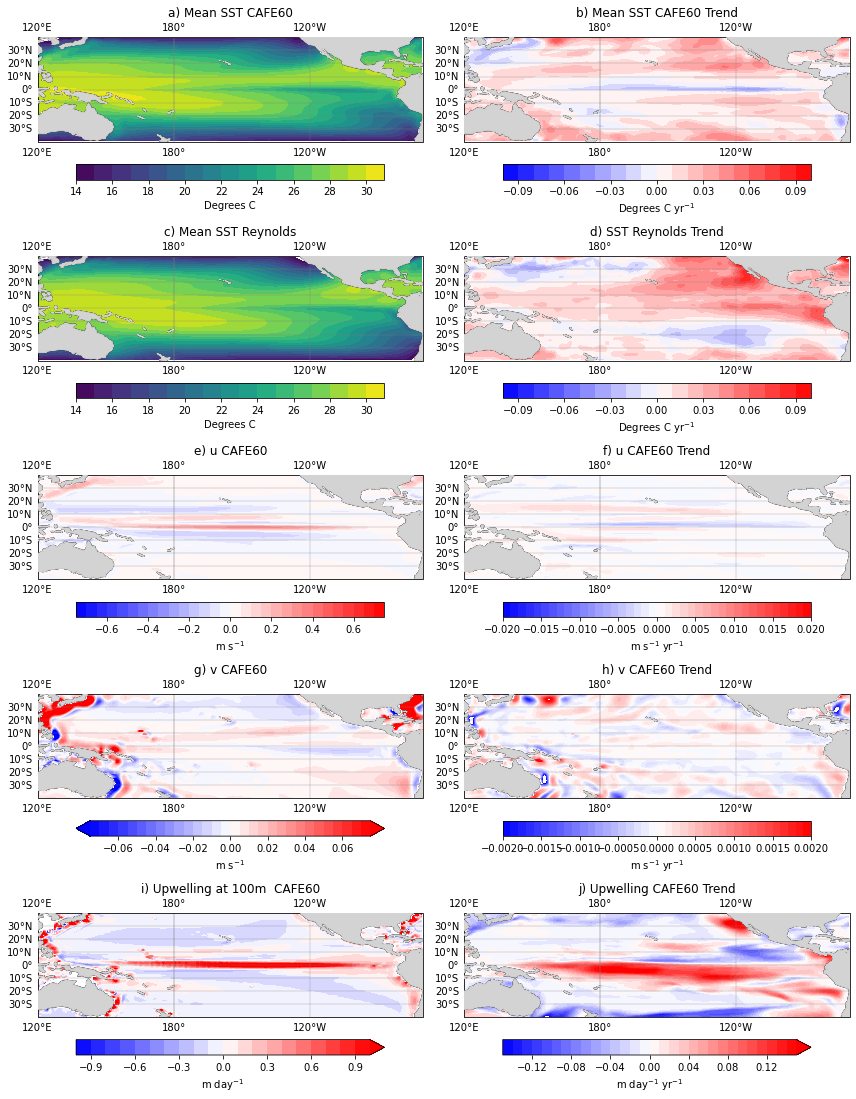

In [31]:
run_f1=True
if run_f1==True:
    sday='2000-01-01'
    eday='2020-01-01'

    # A3 is (11.69,16.53)
    #fig = plt.figure(figsize=((8.27)*1.5,11.69*1.5)) #Inches Portrait
    shrink=0.8
    fig = plt.figure(figsize=(12,18)) #Inches Portrait

    plot_pacific_subplot(cafe_sst.sel(time=slice(sday,eday)).mean(dim='time'),sb=621,title='a) Mean SST CAFE60',levels=np.arange(14,32,1),units='Degrees C',cmap='viridis',shrink=shrink)
    plot_pacific_subplot(cafe_sst_trend.mean(dim='timeperiod').sel(parameter=0),sb=622,title='b) Mean SST CAFE60 Trend',levels=np.arange(-0.1,0.11,0.01),units='Degrees C yr$^{-1}$',shrink=shrink)

    plot_pacific_subplot(rey_sst.sst.sel(time=slice(sday,eday)).mean(dim='time'),sb=623,title='c) Mean SST Reynolds',levels=np.arange(14,32,1),cmap='viridis',units='Degrees C',shrink=shrink)
    plot_pacific_subplot(rey_sst_trend.mean(dim='timeperiod').sel(parameter=0),sb=624,title='d) SST Reynolds Trend',levels=np.arange(-0.1,0.11,0.01),units='Degrees C yr$^{-1}$',shrink=shrink)

    plot_pacific_subplot(cafe_u.chunk({'st_ocean':-1}).mean('st_ocean').rename({'lon_x':'lon','lat_x':'lat'}).sel(time=slice(sday,eday)).mean(dim='time'),sb=625,title='e) u CAFE60',units='m s$^{-1}$',levels=np.arange(-0.75,0.8,0.05),shrink=shrink)
    plot_pacific_subplot(cafe_u_trend.mean(dim='timeperiod').sel(parameter=0).rename({'lon_x':'lon','lat_x':'lat'}),sb=626,title='f) u CAFE60 Trend',units='m s$^{-1}$ yr$^{-1}$',levels=np.arange(-0.02,0.021,0.001),shrink=shrink)

    #plot_pacific_subplot(obs_current.U_320.interpolate_na(dim='lat').interpolate_na(dim='lon').mean(dim=['depth','time']),sb=627,levels=np.arange(-1,1.1,0.1),cmap='bwr',title='g) U TAO Obs',shrink=shrink,small_plot=True,units='m s$^{-1}$')
    #plot_pacific_subplot(obs_current.V_321.interpolate_na(dim='lat').interpolate_na(dim='lon').mean(dim=['depth','time']),cmap='bwr',levels=np.arange(-0.1,0.11,0.01),title='h) V TAO Obs',sb=[6,2,8],shrink=shrink,small_plot=True,units='m s$^{-1}$')


    plot_pacific_subplot(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=627,title='g) v CAFE60',units='m s$^{-1}$',levels=np.arange(-0.075,0.08,0.005),extend='both',shrink=shrink)
    plot_pacific_subplot(cafe_v_trend.mean(dim='timeperiod').sel(parameter=0).rename({'lon_x':'lon','lat_x':'lat'}),sb=[6,2,8],title='h) v CAFE60 Trend',units='m s$^{-1}$ yr$^{-1}$',levels=np.arange(-0.002,0.0021,0.0001),shrink=shrink)


    plot_pacific_subplot(upwelling_cafe.sel(time=slice(sday,eday)).mean(dim='time')*60*60*24,sb=[6,2,9],title='i) Upwelling at 100m  CAFE60',units='m day$^{-1}$',levels=np.arange(-1,1.1,0.1),extend='max',shrink=shrink)
    plot_pacific_subplot(upwelling_cafe_trend.mean(dim='timeperiod').sel(parameter=0)*60*60*24,sb=[6,2,10],title='j) Upwelling CAFE60 Trend',units='m day$^{-1}$ yr$^{-1}$',levels=np.arange(-0.15,0.16,0.01),extend='max',shrink=shrink)
    plt.tight_layout()
    #plt.subplots_adjust(wspace=0)

In [32]:
#(land_co2_trend.mean(dim='timeperiod').sel(parameter=0)*1000).plot()

In [33]:
run_f2=True
shrink=0.8

In [34]:
cluster

# Figure 3 ? 2 for now.

In [35]:
st_ocean_holder=anth_dic_cafe.st_ocean

l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(st_ocean_holder.st_ocean):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)
#st_ocean_holder['depth_diff']=

st_ocean_holder=st_ocean_holder.assign_coords(
    depth_diff=('st_ocean', depth_diffs))

In [36]:
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_alldep.nc').chunk('auto').__xarray_dataarray_variable__
st_ocean_holder['st_ocean']=st_ocean_holder['st_ocean']*-1
anth_dic_cafe=anth_dic_cafe*st_ocean_holder.depth_diff #Cell weighted depth
anth_dic_cafe_integration=anth_dic_cafe.sum(dim='st_ocean').chunk('auto')#.sel(time=slice(sday,eday)).mean(dim='time')
anth_dic_cafe_integration_trend=xarray_get_trend(anth_dic_cafe_integration.sel(time=slice('2000-01-01','2020-01-01')).chunk(dict(time=-1)))

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,


In [37]:
#anth_dic_cafe_integration.mean(dim='time').plot()

In [38]:
#glodap_cant

In [39]:
#anth_dic_cafe.sum(dim='st_ocean').mean(dim='time').plot()

In [40]:
#anth_dic_cafe_integration_trend.chunk('auto').sel(parameter=0).plot()

In [41]:
cluster

In [42]:
glodap_cant=xr.open_dataset('../external_data/GLODAPv2.2016b.Cant.nc')#.Cant
glodap_po4=xr.open_dataset('../external_data/GLODAPv2.2016b.PO4.nc')#.po4
glodap_temp=xr.open_dataset('../external_data/GLODAPv2.2016b.temperature.nc')#.temperature

In [43]:
eqpac_bgc_dic=eqpac[['dic','adic']].chunk('auto').sel(ensemble=25,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).load()

In [44]:
area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})        
    
eqpac_bgc_canth=eqpac_bgc_dic['adic']-eqpac_bgc_dic['dic']
eqpac_bgc_canth=eqpac_bgc_canth*st_ocean_holder.depth_diff##*area_m2
anth_dic_cafe_integration_raw=eqpac_bgc_canth.sum(dim='st_ocean').chunk('auto')#.mean(dim='time')
anth_dic_cafe_integration_raw_trend=xarray_get_trend(anth_dic_cafe_integration_raw.sel(time=slice('2000-01-01','2020-01-01')).chunk(dict(time=-1)))

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,


In [45]:
glodap_integrate=(glodap_cant.Cant.sel(depth_surface=slice(0,32))*glodap_cant.Depth.diff(dim='depth_surface')).sel(lat=slice(-40,40),lon=slice(120,300))#.depth_surface

In [46]:
anth_dic_cafe_integration_raw#(-anth_dic_cafe_integration_raw.chunk('auto').sel(time=slice('2002-01-01','2002-12-31')).mean(dim='time')/1000).sel(lat=slice(-5,5)).T.plot()

<xarray.DataArray (time: 241, lat: 140, lon: 170)>
dask.array<xarray-<this-array>, shape=(241, 140, 170), dtype=float64, chunksize=(241, 140, 170), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
    ensemble  int32 25

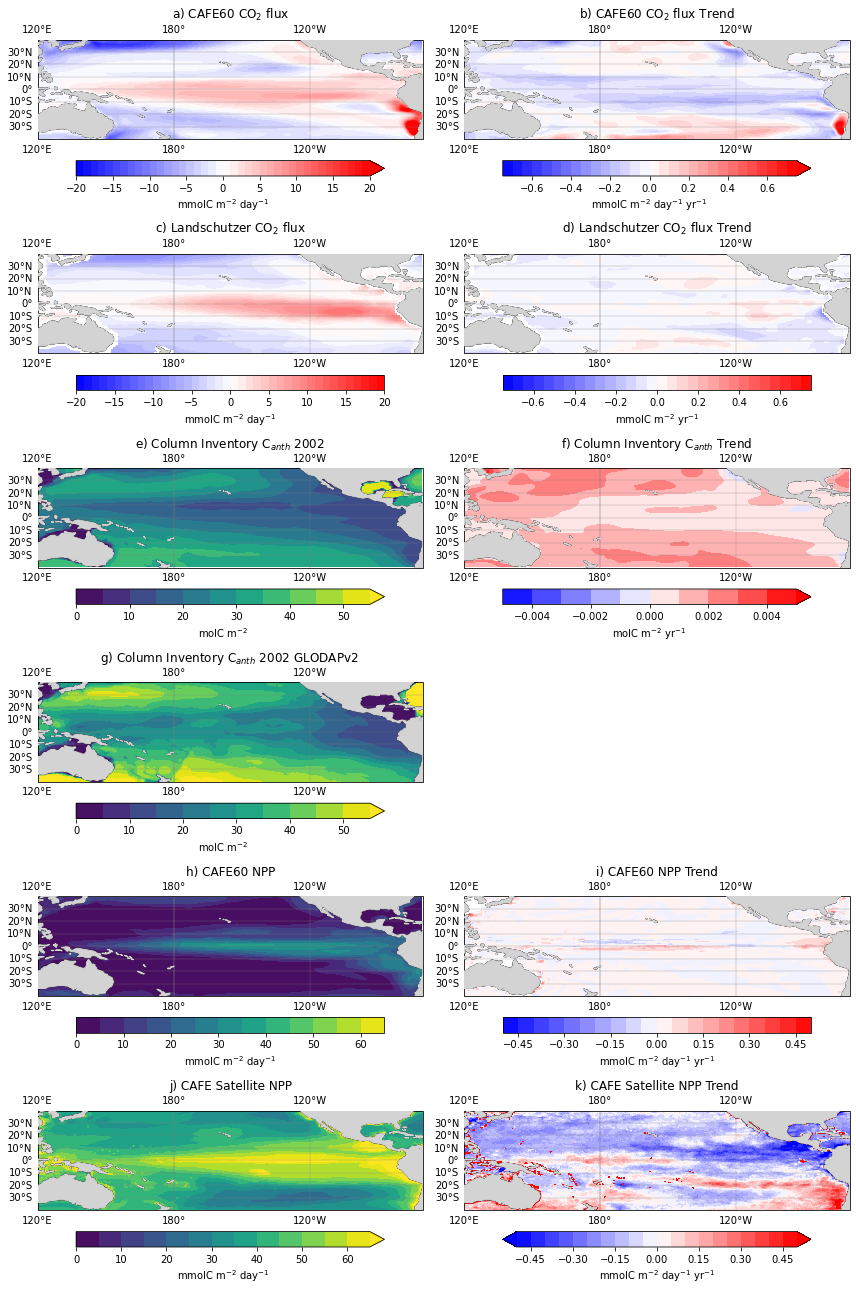

In [47]:
if run_f2==True:
    sday='2000-01-01'
    eday='2020-01-01'
    #fig = plt.figure(figsize=((8.27*2),11.69*2)) #Inches Portrait
    fig = plt.figure(figsize=(12,18)) 
    plot_pacific_subplot(cafe_co2.chunk('auto').sel(time=slice(sday,eday)).mean(dim='time')*60*60*-24,sb=621,title='a) CAFE60 CO$_{2}$ flux',levels=np.arange(-20,21,1),units='mmolC m$^{-2}$ day$^{-1}$',shrink=shrink,extend='max')
    plot_pacific_subplot(cafe_co2_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0)*60*60*-24,sb=622,title='b) CAFE60 CO$_{2}$ flux Trend',levels=np.arange(-0.75,0.8,0.05),units='mmolC m$^{-2}$ day$^{-1}$ yr$^{-1}$',shrink=shrink,extend='max')

    plot_pacific_subplot((land_co2.chunk('auto')).sel(time=slice(sday,eday)).mean(dim='time'),sb=623,title='c) Landschutzer CO$_{2}$ flux',levels=np.arange(-20,21,1),units='mmolC m$^{-2}$ day$^{-1}$',shrink=shrink)
    plot_pacific_subplot(land_co2_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0)*1000,sb=624,title='d) Landschutzer CO$_{2}$ flux Trend',levels=np.arange(-0.75,0.8,0.05),units='mmolC m$^{-2}$ yr$^{-1}$',shrink=shrink)

    #plot_pacific_subplot(cafe_co2_natural.sel(time=slice(sday,eday)).mean(dim='time')*60*60*-24,sb=725,title='Natural CO2',levels=np.arange(-20,21,1),units='mmol/m3',extend='max',shrink=shrink)
    #plot_pacific_subplot(cafe_co2_natural_trend.mean(dim='timeperiod').sel(parameter=0)*60*60*-24,sb=726,title='Natural CO2',levels=np.arange(-0.75,0.8,0.05),units='mmol/m3/yr',extend='max',shrink=shrink)

    plot_pacific_subplot(-anth_dic_cafe_integration_raw.chunk('auto').sel(time=slice('2002-01-01','2002-12-31')).mean(dim='time')/1000,sb=625,title='e) Column Inventory C$_{anth}$ 2002',levels=np.arange(0,60,5),units='molC m$^{-2}$',cmap='viridis',shrink=shrink,extend='max')
    plot_pacific_subplot(-anth_dic_cafe_integration_raw_trend.chunk('auto').sel(parameter=0)/1000,sb=626,title='f) Column Inventory C$_{anth}$ Trend',levels=np.arange(-0.005,0.006,0.001),units='molC m$^{-2}$ yr$^{-1}$',shrink=shrink,extend='max')#,levels=np.arange(-0.025,0.025,0.0025))
    
    plot_pacific_subplot(((glodap_integrate.sum(dim='depth_surface'))/1000),sb=627,title='g) Column Inventory C$_{anth}$ 2002 GLODAPv2 ',levels=np.arange(0,60,5),units='molC m$^{-2}$',cmap='viridis',shrink=shrink,extend='max')

    #anth_dic_cafe_integration_trend
    
    
    #plot_pacific_subplot(dic_cafe.chunk('auto').sel(st_ocean=slice(0,-100)).mean(dim='st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=627,title='g) DIC',levels=np.arange(1800,2250,50),units='mmol m$^{-3}$ ',cmap='viridis',shrink=shrink)
    #plot_pacific_subplot(dic_mean_depth_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0),sb=[6,2,8],title='h) DIC',levels=np.arange(-9,9.25,0.25),units='mmolC m$^{-3} $yr$^{-1}$',shrink=shrink)


    plot_pacific_subplot(cafe_pprod.chunk('auto').sel(time=slice(sday,eday)).mean(dim='time')*60*60*24*6.625 ,sb=[6,2,9],title='h) CAFE60 NPP',units='mmolC m$^{-2}$ day$^{-1}$',cmap='viridis',levels=np.arange(0,70,5),shrink=shrink)
    plot_pacific_subplot(cafe_pprod_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0)*60*60*24*6.625 ,sb=[6,2,10],title='i) CAFE60 NPP Trend',units='mmolC m$^{-2}$ day$^{-1}$ yr$^{-1}$',levels=np.arange(-0.5,0.55,0.05),shrink=shrink)

    plot_pacific_subplot(npp.chunk('auto').sel(time=slice(sday,eday)).mean(dim='time')/12,sb=[6,2,11],title='j) CAFE Satellite NPP',units='mmolC m$^{-2}$ day$^{-1}$',cmap='viridis',levels=np.arange(0,70,5),extend='max',shrink=shrink)#,remap=True)
    plot_pacific_subplot(npp_cafe_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0)/12,sb=[6,2,12],title='k) CAFE Satellite NPP Trend',units='mmolC m$^{-2}$ day$^{-1}$ yr$^{-1}$',levels=np.arange(-0.5,0.55,0.05),extend='both',shrink=shrink)#,remap=True)
    #plot_pacific_subplot(xarray_get_trend(npp.sel(time=slice(sday,eday))).sel(parameter=0)*365,sb=[7,2,14],title='CAFE Satellite NPP Trends',units='mmol/m3/yr')

    plt.tight_layout()
    #plot_pacific_subplot(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=527,title='V Cafe')
    #plot_pacific_subplot(xarray_get_trend(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday))).sel(parameter=0),sb=528,title='V Cafe')


    #plot_pacific_subplot(upwelling.sel(time=slice(sday,eday)).mean(dim='time'),sb=529,title='Upwelling Cafe')
    #plot_pacific_subplot(xarray_get_trend(upwelling.sel(time=slice(sday,eday))).sel(parameter=0),sb=[5,2,10],title='Upwelling Cafe')

In [48]:
#deseasonaliser(xarray_detrend(cafe_co2,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(cafe_co2_natural,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='purple')
#deseasonaliser(xarray_detrend(land_co2,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')

In [49]:
cafe_sst

<xarray.DataArray 'sst' (time: 731, lat: 140, lon: 170)>
[17397800 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      Potential temperature
    standard_name:  sea_surface_temperature
    units:          degrees C
    valid_range:    [-10. 500.]

## Interannual Variability

In [50]:
#Load CO2 and SST OBS PRODUCTS
land_co2=((xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc').chunk('auto').fgco2_smoothed)*1000/12)/365 #g/m2/day  # To mmol/m2/day
rodenbeck_co2=(xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid.nc').co2flux_ocean.chunk('auto')*1000/12)#/365  # To mmol/m2/day
#rodenbeck_co2.sel(lat=slice(-10,10),lon=slice(120,290),time=slice('2000','2020'))

In [51]:
def add_enso_colours(ax1):
#Put in the ENSO box regions
    #ep_events and cp events
    ensofps=['../processed_data/indexes/ep_events_ch2.csv','../processed_data/indexes/la_nina_events_ch2.csv','../processed_data/indexes/cp_events_ch2.csv']
    for whichenso,fp in enumerate(ensofps):
        events=pd.read_csv(fp)
        for ev in events.iterrows():
            endm=np.datetime64(ev[1].end).astype('datetime64[M]')
            endm1=endm-np.timedelta64(1,'M')
            endm2=endm+np.timedelta64(1,'M')
            start=np.datetime64(ev[1].start).astype('datetime64[M]')
          
            if start==endm1: #We don't want to plot events that last for only a month
                pass    
            #elif start==endm2-np.timedelta64(1,'M'): #There was some weirdness with the 2015 event not being continuous, and this fixes it..,
            #    pass
            else:
                if whichenso==0:
                    #if el nino
                    patchcol='darkred'#'firebrick'
                elif whichenso==1:
                    #if la nina
                    patchcol='deepskyblue'
                elif whichenso==2:
                    patchcol='darkorange'
                elif whichenso==3:
                    patchcol='navy'
                rect=patches.Rectangle((start,0),endm-start,10,linewidth=0,alpha=0.3,color=patchcol)
                ax1.add_patch(rect)
                rect=patches.Rectangle((start,-10),endm-start,10,linewidth=0,alpha=0.3,color=patchcol)
                ax1.add_patch(rect)

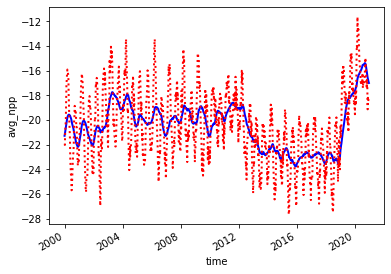

In [52]:
((npp/12).rolling(time=24).mean().sel(lat=slice(15,-15),lon=slice(120,290),time=slice('2000','2020')).chunk(dict(time=-1))).mean(dim=['lat','lon']).plot(c='b',linewidth=2)
((npp/12).sel(lat=slice(15,-15),lon=slice(120,290),time=slice('2000','2020')).chunk(dict(time=-1))).mean(dim=['lat','lon']).plot(c='r',linewidth=2,linestyle=':')


/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_tr

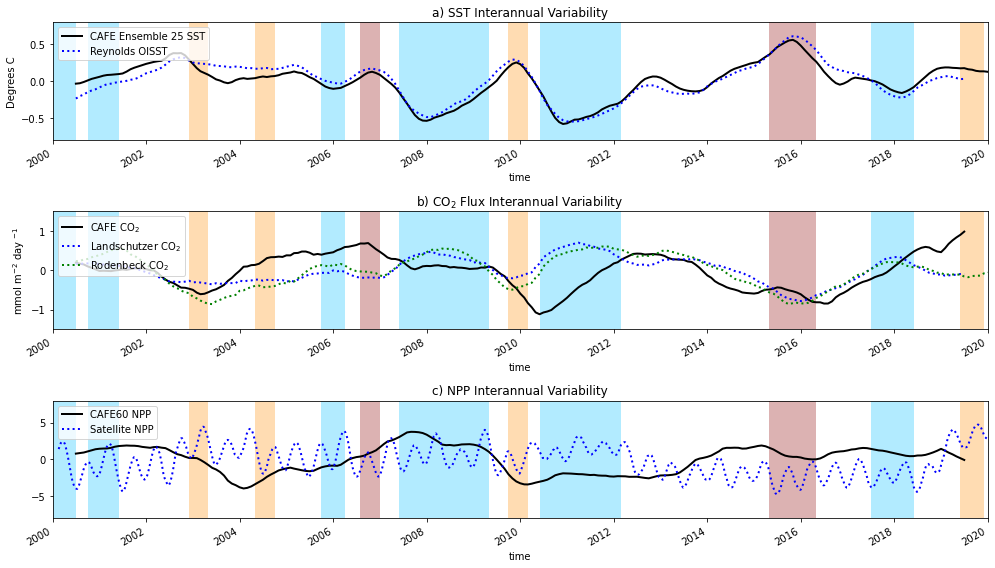

In [53]:
# Interannual Variability?
plt.figure(figsize=(14,8))
ax=plt.subplot(311)
xarray_detrend(cafe_sst.sel(lat=slice(-15,15),time=slice('2000','2020')),keep_intercept_values=False).rolling(time=12,center=True).mean().mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(sst_cafe.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2,linestyle=':')
xarray_detrend(rey_sst.sst.sel(lat=slice(-15,15),time=slice('2000','2020')),keep_intercept_values=False).rolling(time=12,center=True).mean().mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE Ensemble 25 SST','Reynolds OISST'],loc='upper left')
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('a) SST Interannual Variability')
plt.ylabel('Degrees C')
add_enso_colours(ax)
plt.ylim([-0.8,0.8])

ax=plt.subplot(312)
xarray_detrend(cafe_co2.sel(lat=slice(-15,15),time=slice('2000','2020'))*60*60*-24,keep_intercept_values=False).rolling(time=12,center=True).mean().mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(cafe_co2_natural.sel(lat=slice(-15,15),time=slice('2000','2020'))*60*60*-24,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2,linestyle='--')
xarray_detrend(land_co2.sel(lat=slice(-15,15),lon=slice(120,290),time=slice('2000','2020')).chunk(dict(time=-1)),keep_intercept_values=False).rolling(time=12,center=True).mean().mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
xarray_detrend(rodenbeck_co2.sel(lat=slice(-15,15),lon=slice(120,290),time=slice('2000','2020')).chunk(dict(time=-1)),keep_intercept_values=False).rolling(time=12,center=True).mean().mean(dim=['lat','lon']).plot(c='g',linewidth=2,linestyle=':')
plt.legend(['CAFE CO$_{2}$','Landschutzer CO$_{2}$','Rodenbeck CO$_{2}$'],loc='upper left') #'Cafe CO$_{2}$ natural',
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.ylim([-1.5,1.5])
plt.ylabel('mmol m$^{-2}$ day $^{-1}$')
plt.title('b) CO$_{2}$ Flux Interannual Variability')
add_enso_colours(ax)

ax3=plt.subplot(313)
#deseasonaliser(xarray_detrend(npp_cafe_25,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(npp_cafe_25_sed,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linestyle=':',linewidth=2)
(xarray_detrend(cafe_pprod.sel(lat=slice(-15,15),time=slice('2000','2020'))*60*60*24*6.625,keep_intercept_values=False)).rolling(time=12,center=True).mean().mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend((npp.sel(lat=slice(-10,10),time=slice('2000','2020'))/12).chunk(dict(time=-1)),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
(xarray_detrend((npp/12).sel(lat=slice(15,-15),lon=slice(120,290),time=slice('2000','2020')).chunk(dict(time=-1)),keep_intercept_values=False)).rolling(time=12,center=True).mean().mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
#deseasonaliser(xarray_detrend(npp.sel(lat=slice(15,-15),lon=slice(120,290),time=slice('2000','2020')).chunk(dict(time=-1)),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE60 NPP','Satellite NPP'],loc='upper left')
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('c) NPP Interannual Variability')

add_enso_colours(ax3)
plt.ylim([-8,8])
plt.tight_layout()

# Figure 2: EUC Overview

How about including ENSO breakdown?

In [54]:
cafe_u.sel(time=slice('2000','2020'))

<xarray.DataArray 'u' (time: 251, st_ocean: 30, lat_x: 141, lon_x: 171)>
[181555830 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat_x     (lat_x) float64 -39.9 -38.92 -37.95 -36.96 ... 37.9 38.86 39.81
Attributes:
    cell_methods:   time: mean
    long_name:      i-current
    standard_name:  sea_water_x_velocity
    units:          m/sec
    valid_range:    [-10.  10.]

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/plot/plot.py:1417: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contour(x, y, z, **kwargs)
/local/v45/np1383/tmp/ipykernel_3377415/926713506.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])
/local/v45/np1383/tmp/ipykernel_3377415/926713506.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/local/v45/np1383/tmp/ipykernel_3377415/926713506.py:52: UserWarning: FixedFormatter should only be used

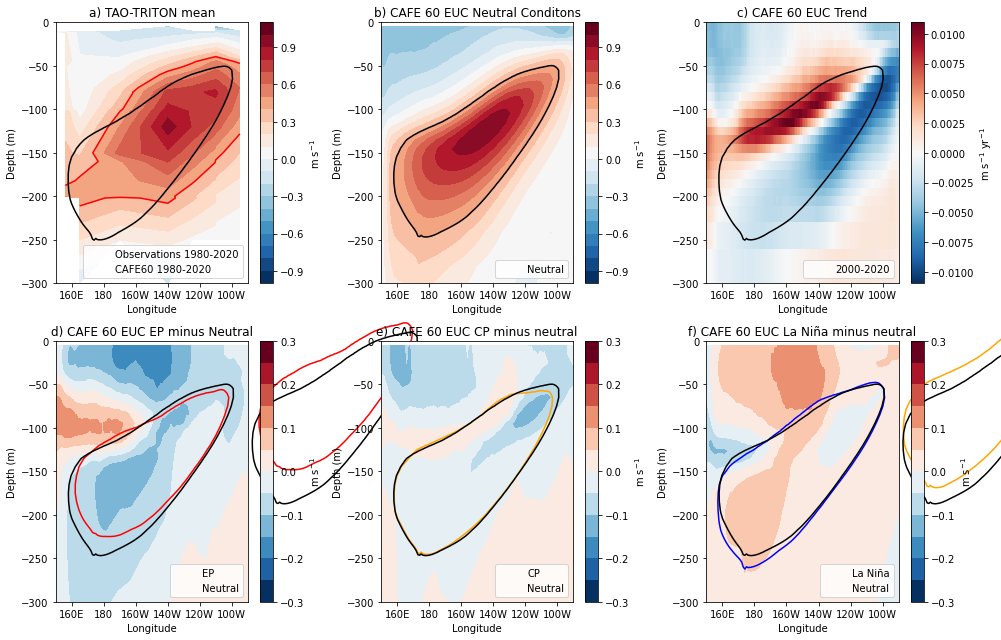

In [55]:
# New EUC Plot
plt.figure(figsize=(14,9))
contour_level=0.4
ax=plt.subplot(231)
euc_obs=obs_current.U_320.sel(lat=slice(-3,3)).mean(dim='lat').interpolate_na('depth').interpolate_na('lon')#.mean(dim=['time']).plot()
euc_obs['depth']=euc_obs['depth']*-1
euc_obs.sel(time=slice('1980','2020')).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1),cbar_kwargs={'label':'m s$^{-1}$'})

obs80=euc_obs.sel(time=slice('1980','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='r',label='Observations (1980-2020)')
cafe80=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=slice('2000','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
#cafe10=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='m')

obs80.collections[0].set_label('Observations 1980-2020')
cafe80.collections[0].set_label('CAFE60 1980-2020')
#cafe10.collections[0].set_label('2010-2020')
plt.legend(loc='lower right')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.title('a) TAO-TRITON mean')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])

ax=plt.subplot(232)
cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1),cbar_kwargs={'label':'m s$^{-1}$'})
neutral_cafe=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
neutral_cafe.collections[0].set_label('Neutral')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('b) CAFE 60 EUC Neutral Conditons')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])



ax=plt.subplot(233)
(xarray_get_trend(cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest')).sel(parameter=0)*365).plot(cbar_kwargs={'label':'m s$^{-1}$ yr$^{-1}$'})
#cafe_u.sel(lat_x=0,method='nearest').mean(dim='time').plot.contour(levels=[contour_level])
cafe80=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=slice('2000','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
#cafe10=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='m')

cafe80.collections[0].set_label('2000-2020')
#cafe10.collections[0].set_label('2010-2020')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('c) CAFE 60 EUC Trend')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])


ax=plt.subplot(234)
(cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=ep_events).mean(dim='time')-cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time')).plot.contourf(levels=np.arange(-0.3,0.35,0.05),cbar_kwargs={'label':'m s$^{-1}$'})


cafe80=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('EP')

neutral_cafe=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
neutral_cafe.collections[0].set_label('Neutral')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('d) CAFE 60 EUC EP minus Neutral')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])

ax=plt.subplot(235)
(cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=cp_events).mean(dim='time')-cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time')).plot.contourf(levels=np.arange(-0.3,0.35,0.05),cbar_kwargs={'label':'m s$^{-1}$'})
cafe80=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[contour_level],colors='orange')
cafe80.collections[0].set_label('CP')

neutral_cafe=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
neutral_cafe.collections[0].set_label('Neutral')

plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('e) CAFE 60 EUC CP minus neutral')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])

ax=plt.subplot(236)
(cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=nina_events).mean(dim='time')-cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time')).plot.contourf(levels=np.arange(-0.3,0.35,0.05),cbar_kwargs={'label':'m s$^{-1}$'})
cafe80=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[contour_level],colors='blue')
cafe80.collections[0].set_label('La Niña')

neutral_cafe=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
neutral_cafe.collections[0].set_label('Neutral')

plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('f) CAFE 60 EUC La Niña minus neutral')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])
plt.tight_layout()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/plot/plot.py:1417: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contour(x, y, z, **kwargs)
/local/v45/np1383/tmp/ipykernel_3377415/1503814402.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])
/local/v45/np1383/tmp/ipykernel_3377415/1503814402.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/local/v45/np1383/tmp/ipykernel_3377415/1503814402.py:65: UserWarning: FixedFormatter should only be u

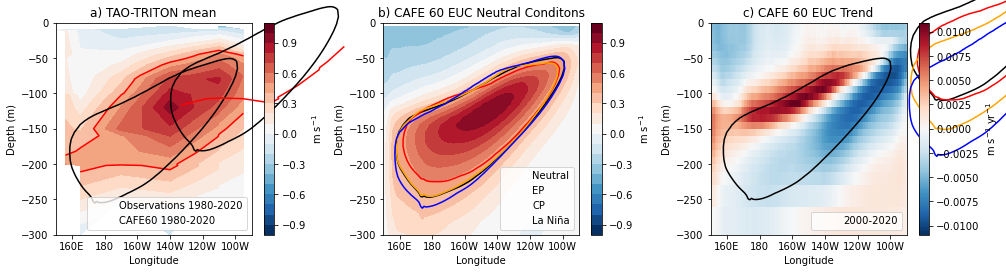

In [56]:
# MODIFIED EUC PLOT NO ENSO (JUST CONTOURS)
plt.figure(figsize=(14,7))
contour_level=0.4
ax=plt.subplot(231)
euc_obs=obs_current.U_320.sel(lat=slice(-3,3)).mean(dim='lat').interpolate_na('depth').interpolate_na('lon')#.mean(dim=['time']).plot()
euc_obs['depth']=euc_obs['depth']*-1
euc_obs.sel(time=slice('1980','2020')).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1),cbar_kwargs={'label':'m s$^{-1}$'})

obs80=euc_obs.sel(time=slice('1980','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='r',label='Observations (1980-2020)')
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
#cafe10=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='m')

obs80.collections[0].set_label('Observations 1980-2020')
cafe80.collections[0].set_label('CAFE60 1980-2020')
#cafe10.collections[0].set_label('2010-2020')
plt.legend(loc='lower right')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.title('a) TAO-TRITON mean')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])

ax=plt.subplot(232)
cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1),cbar_kwargs={'label':'m s$^{-1}$'})
neutral_cafe=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
neutral_cafe.collections[0].set_label('Neutral')

cafe80_ep=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80_ep.collections[0].set_label('EP')

cafe80_cp=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[contour_level],colors='orange')
cafe80_cp.collections[0].set_label('CP')

cafe80_nina=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[contour_level],colors='blue')
cafe80_nina.collections[0].set_label('La Niña')
#neutral_cafe=cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
#neutral_cafe.collections[0].set_label('Neutral')


plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('b) CAFE 60 EUC Neutral Conditons')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])



ax=plt.subplot(233)
(xarray_get_trend(cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest')).sel(parameter=0)*365).plot(cbar_kwargs={'label':'m s$^{-1}$ yr$^{-1}$'})
#cafe_u.sel(lat_x=0,method='nearest').mean(dim='time').plot.contour(levels=[contour_level])
cafe80=cafe_u.sel(time=slice('2000','2020')).sel(lat_x=0,method='nearest').sel(time=slice('1980','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='k')
#cafe10=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='m')
cafe80.collections[0].set_label('2000-2020')

#cafe10.collections[0].set_label('2010-2020')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('c) CAFE 60 EUC Trend')
ax.set_xticklabels(['','160E','180','160W','140W','120W','100W'])

plt.tight_layout()

In [57]:
# ENSO BREAKDOWN

In [58]:
#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')
nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=cafe_co2.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values

/local/v45/np1383/tmp/ipykernel_3377415/3538848497.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
/local/v45/np1383/tmp/ipykernel_3377415/3538848497.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
/local/v45/np1383/tmp/ipykernel_3377415/3538848497.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
/local/v45/np1383/tmp/ipykernel_3377415/3538848497.py:20: FutureWarning: The frame.appen

In [59]:
def plot_cartopy_row(fig,
                     axn,
                     dat,
                     dat_mean,
                     units,
                     title,
                     units_tr=None,
                     levs=None,
                     levs_trend=None,
                     rend_conversion=None,
                     sb1=7,sb2=3,
                     extend=None,
                     cmap='viridis',
                     cmaptr='RdBu_r',
                     wu=None,wv=None, 
                     significance_stiples=False):
    '''
    Create a plotting function to make it repeatable and nicer
    colormaps should either be viridis or RdBu_r
    axis (number) will be 1,3,5,7 (plots both avg and trend at once)
     
    Unfortunately this function does the processing of mean, trends and pvals on the fly.
    Could save these if needed, but not provided here. 
    
    Example Use
    ```
    fig=plt.figure(figsize=(19*2/2.54,23*2/2.54))#(figsize=(30,15))
    sb1=7
    sb2=3



    ```
    '''
    usemap_proj = ccrs.PlateCarree(central_longitude=180)
    usemap_proj._threshold /= 20.  # to make greatcircle smooth


    
    fr=0.03
    fs=12
    ms=10
    startday=np.datetime64('2000-01-01')
    endday=np.datetime64('2020-01-01')
    #ax1=fig.add_subplot(sb1,sb2,axn)
    # Or maybe just subplot ??
    ax = plt.subplot(sb1,sb2,axn,projection=usemap_proj)
    
    ax.set_extent([120, 290, -40, 40], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)


    f=ax.contourf(dat.lon,dat.lat,dat.mean(dim='time')-dat_mean.mean(dim='time'),transform=ccrs.PlateCarree(),cmap=cmap,levels=levs,extend=extend) 
        #Quick anti-aliasing fix as per: https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps
    for c in f.collections:
        c.set_edgecolor("face")

    if title=='SST':
        
        lev=28.5#29.2 #rather than 28.5
        early_sst=dat.sel(time=slice('1997-01-01','2002-01-01')).mean(dim='time')#.where(co2.seamask==1)
        late_sst=dat.sel(time=slice('2015-01-01','2020-01-01')).mean(dim='time')#.where(co2.seamask==1)
       
        ax.contour(dat.lon,dat.lat,early_sst,transform=ccrs.PlateCarree(),levels=[lev],linestyles='dotted',colors='k')
        
        ax.contour(dat.lon,dat.lat,late_sst,transform=ccrs.PlateCarree(),levels=[lev],linestyles='solid',colors='k')
        ax.contour(dat.lon,dat.lat,dat.mean(dim='time'),transform=ccrs.PlateCarree(),levels=[25],linestyles='dashed',colors='k')
        
    
    
    
    #wu['lon'],wu['lat']=m(lo,la,wu.lon.values,wu.lat.values)
    #No windspeed vectors now
    #if title=='Wind speed':
    #      skip=(slice(None,None,4),slice(None,None,4)) #2 for NCEP 2
    #      m.quiver(lo1[skip],la1[skip],wu.mean(dim='time')[skip]/2,wv.mean(dim='time')[skip]/2,scale=90,headwidth=4.5)#,minshaft=2)

    
    
    #LETS do a t-test to see if they where there is significant differnces
    significance_stiples=False
    if significance_stiples==True:
        #Trends
        dat=dat.where(dat!=-0.9999,np.nan)
        #hm=dat.interpolate_na(dim='time').sel(time=slice(startday,endday))
        months=dat.time

        dt_dates=pd.to_numeric(months.values.astype('datetime64[D]'))
        num_dates=dt_dates
        dat['time']=num_dates
        
        anom=np.concatenate(dat.T)
        mean=np.concatenate(dat_mean.T)

        pv=[]
        for i in range(anom.shape[0]):
            #print(xx[i,:])
            stat=ttest_ind(anom[i],dat_mean[i],nan_policy='omit')#linregress(time,xx[i,:])
            #print(stat)
            #tr.append(stat.slope*365)
            pv.append(stat.pvalue)

        pv=np.array(pv).reshape(len(dat.lon),len(dat.lat)).T

        hh=dat.copy()
        hh=hh.drop('time')
        hh['pval']=(['lat','lon'],pv)

        cnt=m.contourf(dat.lon,dat.lat,hh.pval,colors='none',hatches=['.'],levels=[0,0.05])
        #for c in cnt.collections:
        #    c.set_edgecolor("face")
       
    
    #Quick anti-aliasing fix as per: https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps
       
    
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)

    #Colorbar
    cb=plt.colorbar(f,ax=ax,fraction=fr)
    cb.set_label(units,fontsize=fs)
    cb.ax.tick_params(labelsize=fs-1)

    if axn==1:
        name='EP Events'
    elif axn==2:
        name='CP Events'
    elif axn==3:
        name='La Nina Events'
    
    
    if axn<=3:
        ax.set_title(name+'\n'+chr(ord('`')+axn)+') '+title,fontsize=fs)
    else:
        ax.set_title(chr(ord('`')+axn)+') '+title,fontsize=fs)
    print(title)
    ax.tick_params(labelsize=fs)
    ax.set_aspect('auto', adjustable=None)
    

import calendar
def JulianDate_to_MMDDYYY(y,jd):
        """Given a year and julian date, returns an np.datetime64 of the day"""
        month = 1
        while jd - calendar.monthrange(y,month)[1] > 0 and month <= 12:
            jd = jd - calendar.monthrange(y,month)[1]
            month = month + 1
           
        jd=str(jd).zfill(2) #turn into the form 01 02 03 10 etc
        month=str(month).zfill(2)    
        
        return str(y)+'-'+month+'-'+jd
    
def add_date(ds):
        jday=int(ds.attrs['id'][5:8])
        yr=int(ds.attrs['id'][1:5])
        
        #ds.coords['JulDay'] = jday
        date=JulianDate_to_MMDDYYY(yr,jday)
        ds.coords['time'] =  np.datetime64(date)
        return ds

In [60]:

cafe_sst=xr.open_dataset('../processed_data/physics_ds/sst_physics_feb7.nc').sst
#rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc').sel(lon=slice(120,290),lat=slice(-40,40))
rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc').sel(lon=slice(120,290),lat=slice(-40,40))
land_co2=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365 #g/m2/day
land_co2=(land_co2.fgco2_smoothed.sel(lon=slice(120,290),lat=slice(-40,40))/12)*1000
cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10

cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_anth_co2=cafe_co2-cafe_co2_natural

npp=xr.open_dataset('../processed_data/npp_rg/avg_npp_cafe.nc').avg_npp.chunk('auto')
cafe_pprod=xr.open_dataset('../processed_data/physics_ds/pprod_gross_2d_bgc_feb7.nc').pprod_gross_2d



Reynolds SST
Reynolds SST
Reynolds SST
CAFE60 SST
CAFE60 SST
CAFE60 SST
Landschutzer CO$_{2}$ flux
Landschutzer CO$_{2}$ flux
Landschutzer CO$_{2}$ flux
CAFE60 CO2 flux
CAFE60 CO$_{2}$ flux
CAFE60 CO$_{2}$ flux


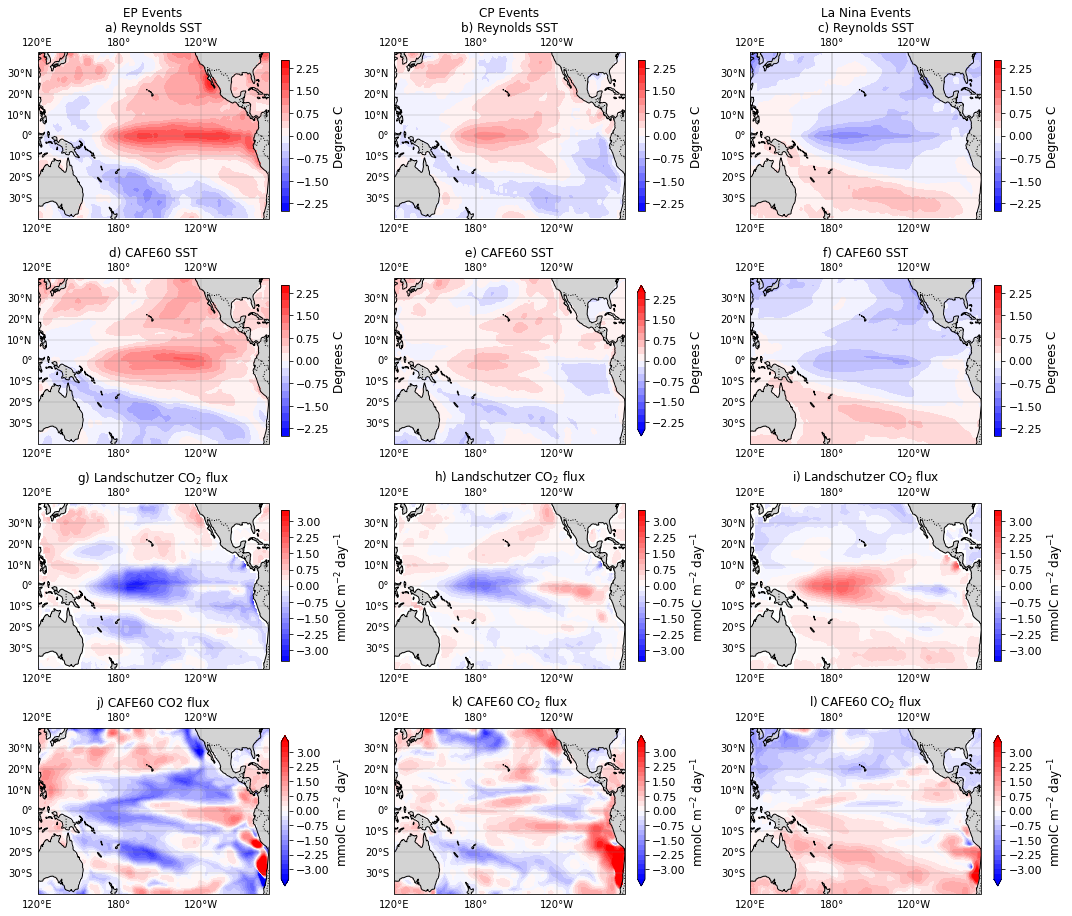

In [61]:

# DEBUG
fig=plt.figure(figsize=(15,22))#(19*2/2.54,28*2/2.54))#(figsize=(30,15))
sb1=7
sb2=3


#%% EP
sst_levs=np.arange(-2.5,2.75,0.25)
co2_levs=np.arange(-3.5,3.75,0.25)
chl_levs=np.arange(-0.1,0.11,0.01)
#Reynolds SST

plot_cartopy_row(fig,axn=1,
                 dat=rey_sst.sst.where(~np.isnan(cafe_sst)).sel(time=ep_events),
                 dat_mean=rey_sst.sst.where(~np.isnan(cafe_sst)).sel(time=all_dates),
                 units='Degrees C',
                 title='Reynolds SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=2,
                 dat=rey_sst.sst.where(~np.isnan(cafe_sst)).sel(time=cp_events),
                 dat_mean=rey_sst.sst.where(~np.isnan(cafe_sst)).sel(time=all_dates),
                 units='Degrees C',
                 title='Reynolds SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=3,
                 dat=rey_sst.sst.where(~np.isnan(cafe_sst)).sel(time=nina_events),
                 dat_mean=rey_sst.sst.where(~np.isnan(cafe_sst)).sel(time=all_dates),
                 units='Degrees C',
                 title='Reynolds SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

# CAFE60 SST
plot_cartopy_row(fig,axn=4,
                 dat=cafe_sst.sel(time=ep_events),
                 dat_mean=cafe_sst.sel(time=all_dates),
                 units='Degrees C',
                 title='CAFE60 SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=5,
                 dat=cafe_sst.sel(time=cp_events),
                 dat_mean=cafe_sst.sel(time=all_dates),
                 units='Degrees C',
                 title='CAFE60 SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr',extend='both')

plot_cartopy_row(fig,axn=6,
                 dat=cafe_sst.sel(time=nina_events),
                 dat_mean=cafe_sst.sel(time=all_dates),
                 units='Degrees C',
                 title='CAFE60 SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')


# LANDSCHUTZER CO2
plot_cartopy_row(fig,axn=7,
                 dat=land_co2.sel(time=ep_events),
                 dat_mean=land_co2.sel(time=all_dates),
                 units='mmolC m$^{-2}$ day$^{-1}$',
                 title='Landschutzer CO$_{2}$ flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=8,
                 dat=land_co2.sel(time=cp_events),
                 dat_mean=land_co2.sel(time=all_dates),
                 units='mmolC m$^{-2}$ day$^{-1}$',
                 title='Landschutzer CO$_{2}$ flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=9,
                 dat=land_co2.sel(time=nina_events),
                 dat_mean=land_co2.sel(time=all_dates),
                 units='mmolC m$^{-2}$ day$^{-1}$',
                 title='Landschutzer CO$_{2}$ flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

#CAFE60 CO2 flux
plot_cartopy_row(fig,axn=10,
                 dat=cafe_co2.sel(time=ep_events)*60*60*-24,#*12*1000,
                 dat_mean=cafe_co2.sel(time=all_dates)*60*60*-24,#*12*1000,
                 units='mmolC m$^{-2}$ day$^{-1}$',
                 title='CAFE60 CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr',extend='both')

plot_cartopy_row(fig,axn=11,
                 dat=cafe_co2.sel(time=cp_events)*60*60*-24,#*12*1000,
                 dat_mean=cafe_co2.sel(time=all_dates)*60*60*-24,#*12*1000,
                 units='mmolC m$^{-2}$ day$^{-1}$',
                 title='CAFE60 CO$_{2}$ flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr',extend='both')

plot_cartopy_row(fig,axn=12,
                 dat=cafe_co2.sel(time=nina_events)*60*60*-24,#*12*1000,
                 dat_mean=cafe_co2.sel(time=all_dates)*60*60*-24,#*12*1000,
                 units='mmolC m$^{-2}$ day$^{-1}$',
                 title='CAFE60 CO$_{2}$ flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr',extend='both')



plt.tight_layout()

In [62]:
# Compare Ensemble 24 vs 25 as they have very different phytoplankton expressions. Do they influence CO2 flux mean / trends?
# How about Canth / Transports?

In [78]:
cluster

In [64]:
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [65]:
pprod32=eqpac.sel(time=slice('2000-01-01','2020-01-01')).pprod_gross_2d.sel(ensemble=32).mean(dim='time')
pprod32_load=pprod32.chunk('auto').load()
print('loaded')

loaded


In [66]:
# Need to compare 32 vs 25, better than 24 vs 25. 

In [67]:
cluster

In [68]:
pprod32=eqpac.sel(time=slice('2000-01-01','2020-01-01')).pprod_gross_2d.sel(ensemble=32)
print(1)
pprod32_load=pprod32.mean(dim='time').chunk('auto').load()
print(2)
pprod32_fat_load=pprod32.sel(lat=slice(-5,5)).mean(dim='time').chunk('auto').load()
print(3)

1
2
3


In [79]:
lat1=-40
lat2=40
pprod24=eqpac.sel(time=slice('2000-01-01','2020-01-01')).pprod_gross_2d.sel(ensemble=24).sel(lat=slice(lat1,lat2)).mean(dim='time')
pprod25=eqpac.sel(time=slice('2000-01-01','2020-01-01')).pprod_gross_2d.sel(ensemble=25).sel(lat=slice(lat1,lat2)).mean(dim='time')
aco2flux24=(eqpac.stf10-eqpac.stf07).sel(time=slice('2000-01-01','2020-01-01')).sel(ensemble=24).sel(lat=slice(lat1,lat2)).mean(dim='time')
aco2flux25=(eqpac.stf10-eqpac.stf07).sel(time=slice('2000-01-01','2020-01-01')).sel(ensemble=25).sel(lat=slice(lat1,lat2)).mean(dim='time')
adic24=(eqpac.adic-eqpac.dic).sel(time=slice('2000-01-01','2020-01-01')).sel(ensemble=24).sel(lat=slice(lat1,lat2)).mean(dim='st_ocean').mean(dim='time')
adic25=(eqpac.adic-eqpac.dic).sel(time=slice('2000-01-01','2020-01-01')).sel(ensemble=24).sel(lat=slice(lat1,lat2)).mean(dim='st_ocean').mean(dim='time')
print('hi')
pprod32=eqpac.sel(time=slice('2000-01-01','2020-01-01')).pprod_gross_2d.sel(ensemble=32).sel(lat=slice(lat1,lat2)).mean(dim='time')
pprod32_load=pprod32.chunk('auto').load()
print('loaded')
pprod24_load=pprod24.chunk('auto').load()
print('loaded')
pprod25_load=pprod25.chunk('auto').load()
print('loaded')

pprod8=eqpac.sel(lat=slice(-5,5)).sel(time=slice('2000-01-01','2020-01-01')).pprod_gross_2d.sel(ensemble=8).mean(dim='time')
pprod8_load=pprod8.chunk('auto').load()

pprod96=eqpac.sel(lat=slice(-5,5)).sel(time=slice('2000-01-01','2020-01-01')).pprod_gross_2d.sel(ensemble=96).mean(dim='time')
pprod96_load=pprod96.chunk('auto').load()

pprod1=eqpac.sel(lat=slice(-5,5)).sel(time=slice('2000-01-01','2020-01-01')).pprod_gross_2d.sel(ensemble=1).mean(dim='time')
pprod1_load=pprod1.chunk('auto').load()

pprod89=eqpac.sel(lat=slice(-5,5)).sel(time=slice('2000-01-01','2020-01-01')).pprod_gross_2d.sel(ensemble=89).mean(dim='time')
pprod89_load=pprod89.chunk('auto').load()


hi
loaded
loaded
loaded


In [80]:
pprod1=eqpac.sel(time=slice('2000-01-01','2020-01-01')).pprod_gross_2d.sel(ensemble=1).mean(dim='time')
pprod1_load=pprod1.chunk('auto').load()

pprod89=eqpac.sel(time=slice('2000-01-01','2020-01-01')).pprod_gross_2d.sel(ensemble=89).mean(dim='time')
pprod89_load=pprod89.chunk('auto').load()


In [81]:
aco2flux24_load=aco2flux24.chunk('auto').load()
print('loaded')
aco2flux25_load=aco2flux25.chunk('auto').load()
print('loaded')

loaded
loaded


In [86]:
adic24_load=adic24.chunk('auto').load()
print('loaded')
adic25_load=adic25.chunk('auto').load()
print('loaded')

loaded
loaded


In [87]:
co2flux24=(eqpac.stf10).sel(time=slice('2000-01-01','2020-01-01')).sel(ensemble=24)#.mean(dim='time')
co2flux25=(eqpac.stf10).sel(time=slice('2000-01-01','2020-01-01')).sel(ensemble=25)#.mean(dim='time')

co2flux24_load=co2flux24.chunk('auto').load()
print('loaded')
co2flux25_load=co2flux25.chunk('auto').load()
print('loaded')

co2flux24_load_mean=co2flux24.chunk('auto').mean(dim='time').load()
print('loaded')
co2flux25_load_mean=co2flux25.chunk('auto').mean(dim='time').load()
print('loaded')



loaded
loaded
loaded
loaded


In [88]:
(pprod24_load*60*60*24*6.625).mean().values

array(6.542682, dtype=float32)

In [89]:
(pprod25_load*60*60*24*6.625).mean().values

array(10.199407, dtype=float32)

In [90]:
(pprod32_load*60*60*24*6.625).mean().values

array(6.633688, dtype=float32)

In [91]:
(pprod8_load*60*60*24*6.625).mean().values

array(15.762358, dtype=float32)

In [92]:
(pprod96_load*60*60*24*6.625).mean().values

array(12.368026, dtype=float32)

In [93]:
(pprod1_load*60*60*24*6.625).mean().values

array(12.356608, dtype=float32)

In [94]:
(pprod89_load*60*60*24*6.625).mean().values

array(6.2699027, dtype=float32)

In [95]:
eqpac.pprod_gross_2d

,Array,Chunk
Bytes,6.22 GiB,8.72 MiB
Shape,"(731, 96, 140, 170)","(1, 96, 140, 170)"
Count,1463 Tasks,731 Chunks
Type,float32,numpy.ndarray


/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,


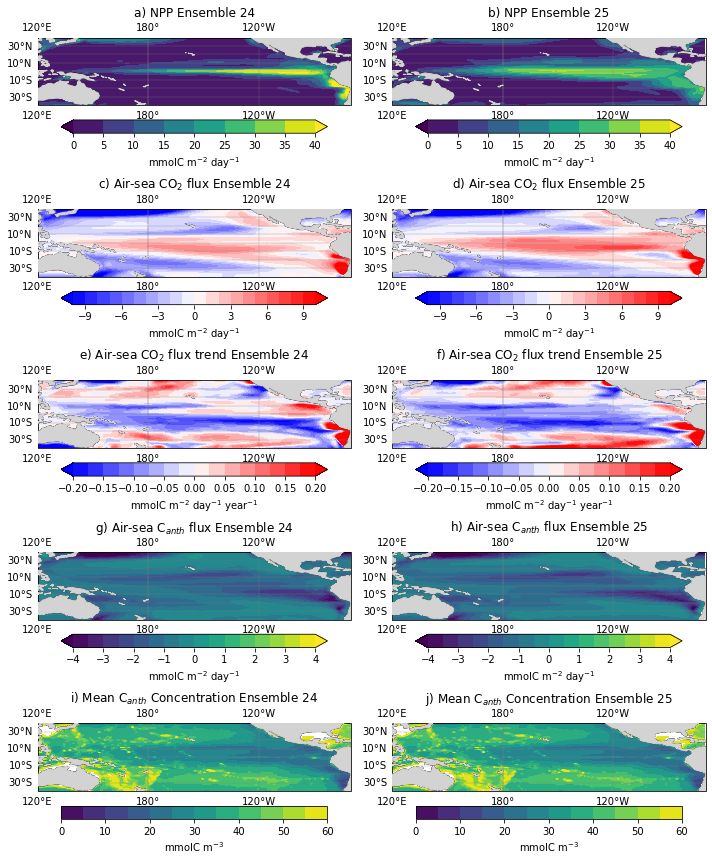

In [96]:
fig = plt.figure(figsize=(10,12))
plot_pacific_subplot(pprod24_load*60*60*24*6.625,sb=521,title='a) NPP Ensemble 24',levels=np.arange(0,45,5),extend='both',cmap='viridis',units='mmolC m$^{-2}$ day$^{-1}$')
plot_pacific_subplot(pprod25_load*60*60*24*6.62,sb=522,title='b) NPP Ensemble 25',levels=np.arange(0,45,5),extend='both',cmap='viridis',units='mmolC m$^{-2}$ day$^{-1}$')#.chunk('auto').mean(dim='timeperiod').sel(parameter=0)*60*60*-24,sb=622,title='b) CAFE60 CO$_{2}$ Trend',levels=np.arange(-0.75,0.8,0.05),units='mmolC m$^{-2}$ day$^{-1}$ yr$^{-1}$',shrink=shrink,extend='max')

plot_pacific_subplot(co2flux24_load_mean*60*60*-24,sb=523,title='c) Air-sea CO$_{2}$ flux Ensemble 24',levels=np.arange(-10,11,1),extend='both',units='mmolC m$^{-2}$ day$^{-1}$')#(land_co2.chunk('auto')).sel(time=slice(sday,eday)).mean(dim='time'),sb=623,title='c) Landschutzer CO$_{2}$',levels=np.arange(-20,21,1),units='mmolC m$^{-2}$ day$^{-1}$',shrink=shrink)
plot_pacific_subplot(co2flux25_load_mean*60*60*-24,sb=524,title='d) Air-sea CO$_{2}$ flux Ensemble 25',levels=np.arange(-10,11,1),extend='both',units='mmolC m$^{-2}$ day$^{-1}$')#land_co2_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0)*1000,sb=624,title='d) Landschutzer CO$_{2}$ Trend',levels=np.arange(-0.75,0.8,0.05),units='mmolC m$^{-2}$ yr$^{-1}$',shrink=shrink)

plot_pacific_subplot((xarray_get_trend(co2flux24_load*60*60*-24).sel(parameter=0)*365),sb=525,title='e) Air-sea CO$_{2}$ flux trend Ensemble 24',levels=np.arange(-0.2,0.225,0.025),extend='both',units='mmolC m$^{-2}$ day$^{-1}$ year$^{-1}$')#(land_co2.chunk('auto')).sel(time=slice(sday,eday)).mean(dim='time'),sb=623,title='c) Landschutzer CO$_{2}$',levels=np.arange(-20,21,1),units='mmolC m$^{-2}$ day$^{-1}$',shrink=shrink)
plot_pacific_subplot((xarray_get_trend(co2flux25_load*60*60*-24).sel(parameter=0)*365),sb=526,title='f) Air-sea CO$_{2}$ flux trend Ensemble 25',levels=np.arange(-0.2,0.225,0.025),extend='both',units='mmolC m$^{-2}$ day$^{-1}$ year$^{-1}$')#land_co2_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0)*1000,sb=624,title='d) Landschutzer CO$_{2}$ Trend',levels=np.arange(-0.75,0.8,0.05),units='mmolC m$^{-2}$ yr$^{-1}$',shrink=shrink)

plot_pacific_subplot(aco2flux24_load*60*60*-24,sb=527,title='g) Air-sea C$_{anth}$ flux Ensemble 24',levels=np.arange(-4,4.5,0.5),extend='both',cmap='viridis',units='mmolC m$^{-2}$ day$^{-1}$')#(land_co2.chunk('auto')).sel(time=slice(sday,eday)).mean(dim='time'),sb=623,title='c) Landschutzer CO$_{2}$',levels=np.arange(-20,21,1),units='mmolC m$^{-2}$ day$^{-1}$',shrink=shrink)
plot_pacific_subplot(aco2flux25_load*60*60*-24,sb=528,title='h) Air-sea C$_{anth}$ flux Ensemble 25',levels=np.arange(-4,4.5,0.5),extend='both',cmap='viridis',units='mmolC m$^{-2}$ day$^{-1}$')#land_co2_trend.chunk('auto').mean(dim='timeperiod').sel(parameter=0)*1000,sb=624,title='d) Landschutzer CO$_{2}$ Trend',levels=np.arange(-0.75,0.8,0.05),units='mmolC m$^{-2}$ yr$^{-1}$',shrink=shrink)

plot_pacific_subplot(adic24_load,sb=529,title='i) Mean C$_{anth}$ Concentration Ensemble 24',levels=np.arange(0,65,5),cmap='viridis',units='mmolC m$^{-3}$')#np.arange(0.008,4,0.5))#.sel(time=slice(sday,eday)).mean(dim='time')*60*60*-24,sb=725,title='Natural CO2',levels=np.arange(-20,21,1),units='mmol/m3',extend='max',shrink=shrink)
plot_pacific_subplot(adic25_load,sb=[5,2,10],title='j) Mean C$_{anth}$ Concentration Ensemble 25',levels=np.arange(0,65,5),cmap='viridis',units='mmolC m$^{-3}$')#np.arange(-4,4,0.5))#.mean(dim='timeperiod').sel(parameter=0)*60*60*-24,sb=726,title='Natural CO2',levels=np.arange(-0.75,0.8,0.05),units='mmol/m3/yr',extend='max',shrink=shrink)

plt.tight_layout()

In [ ]:
eqpac_bgc_xsections=eqpac[['no3','dic','adic']].chunk('auto').sel(lat=0,ensemble=25,method='nearest').sel(time=slice('2002-01-01','2002-12-31')).mean(dim='time').load()

In [ ]:
eqpac_temp_xsections=phys_eqpac.temp.chunk('auto').sel(lat=0,ensemble=25,method='nearest').sel(time='2002-01-01').load()

In [ ]:
eqpac_temp_xsections_72_13=phys_eqpac.temp.chunk('auto').sel(lat=0,ensemble=25,method='nearest').sel(time=slice('1972-01-01','2013-12-31')).mean(dim='time').load()

In [ ]:
eqpac_temp_xsections_05_17=phys_eqpac.temp.chunk('auto').sel(lat=0,ensemble=25,method='nearest').sel(time=slice('2005-01-01','2017-12-31')).mean(dim='time').load()

In [ ]:
eqpac_bgc_xsections_80_17=eqpac['no3'].chunk('auto').sel(lat=0,ensemble=25,method='nearest').sel(time=slice('1980-01-01','2017-12-31')).mean(dim='time').load()

In [ ]:
eqpac_bgc_xsections

In [ ]:
# Quick Glodap Equatorial Crosssections
glodap_cant=xr.open_dataset('../external_data/GLODAPv2.2016b.Cant.nc').Cant
glodap_po4=xr.open_dataset('../external_data/GLODAPv2.2016b.PO4.nc').PO4
glodap_temp=xr.open_dataset('../external_data/GLODAPv2.2016b.temperature.nc').temperature

st_depths={1:0,2:10,3:20,4:30,5:50,6:75,7:100,8:125,9:150,
    10:200,11:250,12:300,13:400,14:500,15:600,16:700,17:800,
    18:900,19:1000,20:1100,21:1200,22:1300,23:1400,24:1500,25:1750,
    26:2000,27:2500,28:3000,29:3500,
    30:4000,31:4500,32:5000,33:5500}

glodap_temp=glodap_temp.assign_coords(depth_surface=list(st_depths.values())).rename({'depth_surface':'st_ocean'}).interp(st_ocean=eqpac_temp_xsections.st_ocean.values)#
glodap_po4=glodap_po4.assign_coords(depth_surface=list(st_depths.values())).rename({'depth_surface':'st_ocean'}).interp(st_ocean=eqpac_temp_xsections.st_ocean.values)#
glodap_cant=glodap_cant.assign_coords(depth_surface=list(st_depths.values())).rename({'depth_surface':'st_ocean'}).interp(st_ocean=eqpac_temp_xsections.st_ocean.values)#

In [ ]:
#glodap_cant=xr.open_dataset('../external_data/GLODAPv2.2016b.Cant.nc').Cant
woa_po4=xr.open_dataset('../external_data/woa18_all_p00_01.nc',decode_times=False)#.PO4
woa_temp=xr.open_dataset('../external_data/woa18_decav_t00_01.nc',decode_times=False)#.temperature
woa_temp_2005_2017=xr.open_dataset('../external_data/woa18_2005-2017_t00_01.nc',decode_times=False)#.temperature

woa_temp=woa_temp.assign_coords(lon=(woa_temp.lon%360)).roll(lon=(woa_temp.dims['lon']//2),roll_coords=True)
woa_temp=woa_temp.interp(depth=eqpac_temp_xsections.st_ocean.values).mean(dim='time').sel(lat=0,method='nearest').t_an.sel(lon=slice(120,300))

woa_po4=woa_po4.assign_coords(lon=(woa_po4.lon%360)).roll(lon=(woa_po4.dims['lon']//2),roll_coords=True)
woa_po4=woa_po4.interp(depth=eqpac_temp_xsections.st_ocean.values).mean(dim='time').sel(lat=0,method='nearest').p_an.sel(lon=slice(120,300))

woa_temp_2005_2017=woa_temp_2005_2017.assign_coords(lon=(woa_temp_2005_2017.lon%360)).roll(lon=(woa_temp_2005_2017.dims['lon']//2),roll_coords=True)
woa_temp_2005_2017=woa_temp_2005_2017.interp(depth=eqpac_temp_xsections.st_ocean.values).mean(dim='time').sel(lat=0,method='nearest').t_an.sel(lon=slice(120,300))

In [ ]:
#woa_temp['lon']=woa_temp['lon']+180
#woa_temp.sel(lat=0).t_mn

In [ ]:
woa_temp_2005_2017.plot()
plt.show()
woa_po4.plot()

In [ ]:
glodap_temp=glodap_temp.assign_coords(depth_surface=list(st_depths.values())).rename({'depth_surface':'st_ocean'}).interp(st_ocean=eqpac_temp_xsections.st_ocean.values)#
glodap_po4=glodap_po4.assign_coords(depth_surface=list(st_depths.values())).rename({'depth_surface':'st_ocean'}).interp(st_ocean=eqpac_temp_xsections.st_ocean.values)#
glodap_cant=glodap_cant.assign_coords(depth_surface=list(st_depths.values())).rename({'depth_surface':'st_ocean'}).interp(st_ocean=eqpac_temp_xsections.st_ocean.values)#

In [ ]:
woa_po4 #1960 to 2020

In [ ]:
woa_temp

In [ ]:
glodap_cant

In [ ]:
plt.figure(figsize=(13,9))
ylim=[1200,0]

plt.subplot(331)
glodap_temp.sel(lat=0,method='nearest').sel(lon=slice(120,290)).plot.contourf(levels=np.arange(6,30,2),cbar_kwargs=dict(label='Temperature (C)'))
plt.ylim(ylim)
plt.xlabel('Longitude')
plt.ylabel('Depth')
plt.title('a) GLODAPv2 Temperature')

plt.subplot(332)
eqpac_temp_xsections_72_13.plot.contourf(levels=np.arange(6,30,2),cbar_kwargs=dict(label='Temperature (C)'))
plt.ylim(ylim)
plt.title('b) CAFE60 Temperature')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.subplot(333)
(eqpac_temp_xsections_72_13-glodap_temp.sel(lat=0,method='nearest').sel(lon=slice(120,290))).plot.contourf(levels=np.arange(-4,4.5,0.5),cbar_kwargs=dict(label='Temperature (C)'))
plt.ylim(ylim)
plt.title('c) CAFE60-GLODAPv2 Temperature')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.subplot(334)
glodap_po4.sel(lat=0,method='nearest').sel(lon=slice(120,290)).plot.contourf(levels=np.arange(0,3.4,0.2),cbar_kwargs=dict(label='mmol m$^3$'))#(vmin=-5,vmax=28)
plt.ylim(ylim)
plt.title('d) GLODAPv2 Phosphate')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.subplot(335)
(eqpac_bgc_xsections_72_13/16).plot.contourf(levels=np.arange(0,3.4,0.2),cbar_kwargs=dict(label='mmol m$^3$'))#(vmin=-5,vmax=28)
plt.ylim(ylim)
plt.title('e) CAFE60 Phosphate')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.subplot(336)
((eqpac_bgc_xsections_72_13/16)-glodap_po4.sel(lat=0,method='nearest').sel(lon=slice(120,290))).plot.contourf(levels=np.arange(-1,1.1,0.1),cbar_kwargs=dict(label='mmol m$^3$'))
plt.ylim(ylim)
plt.title('f) CAFE60-GLODAPv2 Phosphate')
plt.xlabel('Longitude')
plt.ylabel('Depth')


plt.subplot(337)
glodap_cant.sel(lat=0,method='nearest').sel(lon=slice(120,290)).plot.contourf(levels=np.arange(0,65,5),cbar_kwargs=dict(label='mmol m$^3$'),cmap='viridis')#(vmin=-5,vmax=28)
plt.ylim(ylim)
plt.title('g) GLODAPv2 C$_{anth}$ 2002')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.subplot(338)
(eqpac_bgc_xsections['adic']-eqpac_bgc_xsections['dic']).plot.contourf(levels=np.arange(0,65,5),cbar_kwargs=dict(label='mmol m$^3$'),cmap='viridis')#(vmin=-5,vmax=28)
plt.ylim(ylim)
plt.title('h) GLODAPv2 C$_{anth}$ 2002')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.subplot(339)
((eqpac_bgc_xsections['adic']-eqpac_bgc_xsections['dic'])-glodap_cant.sel(lat=0,method='nearest').sel(lon=slice(120,290))).plot.contourf(levels=np.arange(-20,22,2),cbar_kwargs=dict(label='mmol m$^3$'))
plt.ylim(ylim)
plt.title('i) CAFE60-GLODAPv2 C$_{anth}$ 2002')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()

In [ ]:
#woa_temp_2005_2017
woa_temp_2005_2017.interpolate_na(dim='depth').interpolate_na(dim='lon').plot()
plt.show()
woa_po4.interpolate_na(dim='depth').interpolate_na(dim='lon').plot()

In [ ]:
(eqpac_temp_xsections_05_17-woa_temp_2005_2017.rename({'depth':'st_ocean'}))

In [ ]:
plt.figure(figsize=(13,9))
ylim=[1200,0]

plt.subplot(331)
woa_temp_2005_2017.interpolate_na(dim='depth').interpolate_na(dim='lon').plot.contourf(levels=np.arange(6,30,2),cbar_kwargs=dict(label='Temperature (C)'))
plt.ylim(ylim)
plt.xlabel('Longitude')
plt.ylabel('Depth')
plt.title('a) WOA 2005-2017 Temperature')

plt.subplot(332)
eqpac_temp_xsections_05_17.plot.contourf(levels=np.arange(6,30,2),cbar_kwargs=dict(label='Temperature (C)'))
plt.ylim(ylim)
plt.title('b) CAFE60 2005-2017 Temperature')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.subplot(333)
(eqpac_temp_xsections_05_17-woa_temp_2005_2017.rename({'depth':'st_ocean'})).plot.contourf(levels=np.arange(-4,4.5,0.5),cbar_kwargs=dict(label='Temperature (C)'))
plt.ylim(ylim)
plt.title('c) CAFE60-WOA Temperature')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.subplot(334)
woa_po4.plot.contourf(levels=np.arange(0,3.4,0.2),cbar_kwargs=dict(label='mmol m$^3$'))#(vmin=-5,vmax=28)
plt.ylim(ylim)
plt.title('d) WOA Phosphate')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.subplot(335)
(eqpac_bgc_xsections_80_17/16).plot.contourf(levels=np.arange(0,3.4,0.2),cbar_kwargs=dict(label='mmol m$^3$'))#(vmin=-5,vmax=28)
plt.ylim(ylim)
plt.title('e) CAFE60 Phosphate')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.subplot(336)
((eqpac_bgc_xsections_80_17/16)-woa_po4.rename({'depth':'st_ocean'})).plot.contourf(levels=np.arange(-1,1.1,0.1),cbar_kwargs=dict(label='mmol m$^3$'))
plt.ylim(ylim)
plt.title('f) CAFE60-WOA Phosphate')
plt.xlabel('Longitude')
plt.ylabel('Depth')


plt.subplot(337)
glodap_cant.sel(lat=0,method='nearest').sel(lon=slice(120,290)).plot.contourf(levels=np.arange(0,65,5),cbar_kwargs=dict(label='mmol m$^3$'),cmap='viridis')#(vmin=-5,vmax=28)
plt.ylim(ylim)
plt.title('g) GLODAPv2 C$_{anth}$ 2002')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.subplot(338)
(eqpac_bgc_xsections['adic']-eqpac_bgc_xsections['dic']).plot.contourf(levels=np.arange(0,65,5),cbar_kwargs=dict(label='mmol m$^3$'),cmap='viridis')#(vmin=-5,vmax=28)
plt.ylim(ylim)
plt.title('h) GLODAPv2 C$_{anth}$ 2002')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.subplot(339)
((eqpac_bgc_xsections['adic']-eqpac_bgc_xsections['dic'])-glodap_cant.sel(lat=0,method='nearest').sel(lon=slice(120,290))).plot.contourf(levels=np.arange(-20,22,2),cbar_kwargs=dict(label='mmol m$^3$'))
plt.ylim(ylim)
plt.title('i) CAFE60-GLODAPv2 C$_{anth}$ 2002')
plt.xlabel('Longitude')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()

In [ ]:
glodap_po4.sel(lat=0,method='nearest').sel(lon=slice(120,290)).plot()#(vmin=-5,vmax=28)
plt.ylim([6000,0])
plt.show()
(eqpac_bgc_xsections['no3']/16).plot()#(vmin=-5,vmax=28)
plt.ylim([6000,0])
plt.show()
((eqpac_bgc_xsections['no3']/16)-glodap_po4.sel(lat=0,method='nearest').sel(lon=slice(120,290))).plot()
plt.ylim([6000,0])
plt.show()

In [ ]:
glodap_cant.sel(lat=0,method='nearest').sel(lon=slice(120,290)).plot()#(vmin=-5,vmax=28)
plt.ylim([6000,0])
plt.show()
(eqpac_bgc_xsections['adic']-eqpac_bgc_xsections['dic']).plot()#(vmin=-5,vmax=28)
plt.ylim([6000,0])
plt.show()
((eqpac_bgc_xsections['adic']-eqpac_bgc_xsections['dic'])-glodap_cant.sel(lat=0,method='nearest').sel(lon=slice(120,290))).plot()
plt.ylim([6000,0])
plt.show()

In [ ]:
glodap_cant

In [ ]:
glodap_po4.sel(lat=0,method='nearest').sel(lon=slice(120,300))#.depth_surface

In [ ]:
aco2flux24

In [ ]:
adic24